# Contents

In this notebook, we will create a RealNVP(real-valued non-volume preserving) generative model for the MNIST dataset, with an intermediate AutoEncoder.

Instead of training the model on direct pixel values and generating images, we will

1. Train an AutoEncoder for the images
2. Convert the data into embeddings using the AutoEncoder's encoder
3. Train our RealNVP model on the embeddings
4. Generate embeddings using the RealNVP model and convert them to images using the AutoEncoder's decoder

This notebook is heavily based on [This Repo](https://github.com/SpencerSzabados/realnvp-pytorch/tree/master)

In [97]:
import copy

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
from torch import nn, distributions
from torch.nn import BCELoss
from torch.nn import functional as F
from torchvision import datasets, transforms

In [98]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [99]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Loading Data

In [100]:
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
train_set = datasets.MNIST('./data',
                           train=True,
                           download=True,
                           transform=transform,)

BATCH_SIZE = 100

train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

### Autoencoder definition

# **📌 Autoencoder for Dimensionality Reduction**
Before we build the Normalizing Flow, we first need a way to represent the high-dimensional MNIST images (28x28 = 784 pixels) in a much smaller, more manageable space. An **Autoencoder** is perfect for this task.

## **🔹 How it Works**
1️⃣ **Encoder**: A neural network that compresses the input image into a low-dimensional latent vector (embedding). This embedding captures the most important features of the image.

2️⃣ **Decoder**: Another neural network that reconstructs the original image from the latent vector.

By training the Autoencoder to minimize the difference between the original and reconstructed image, the encoder learns to create meaningful, information-rich embeddings. We will then train our Normalizing Flow model on these embeddings instead of the raw pixel data.



## **📌 Expected Input & Output Shapes**
- **Input Image:** `(batch_size, 1, 28, 28)`
- **Latent Embedding:** `(batch_size, 20)`  *(20 is our `EMBEDDING_DIM`)*
- **Reconstructed Image:** `(batch_size, 1, 28, 28)`

In [101]:
EMBEDDING_DIM = 20      # The dimension of the embeddings

In [102]:
class Autoencoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        # Encoder compresses 784 pixels -> 128 -> 64 -> embedding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.embedding_dim)
        )
        # Decoder expands embedding_dim -> 64 -> 128 -> 784 pixels
        self.decoder = nn.Sequential(
            nn.Linear(self.embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Use Sigmoid for pixel values between 0 and 1
        )

    def forward(self, x):
        # Flatten the image for the linear layers
        x = x.view(x.size(0), -1)
        embedding = self.encoder(x)
        reconstructed = self.decoder(embedding)
        # Reshape the output to the original image shape
        reconstructed = reconstructed.view(x.size(0), 1, 28, 28)
        return reconstructed, embedding

### Autoencoder training on MNIST

In [103]:
ae_model = Autoencoder(EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
num_epochs = 10

ae_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        
        # Forward pass
        reconstructed, _ = ae_model(images)
        loss = loss_fn(reconstructed, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 600/600 [00:02<00:00, 296.04it/s]


Epoch [1/10], Average Loss: 0.2436


Epoch 2/10: 100%|██████████| 600/600 [00:02<00:00, 253.56it/s]


Epoch [2/10], Average Loss: 0.1541


Epoch 3/10: 100%|██████████| 600/600 [00:03<00:00, 185.65it/s]


Epoch [3/10], Average Loss: 0.1351


Epoch 4/10: 100%|██████████| 600/600 [00:03<00:00, 198.42it/s]


Epoch [4/10], Average Loss: 0.1251


Epoch 5/10: 100%|██████████| 600/600 [00:02<00:00, 200.91it/s]


Epoch [5/10], Average Loss: 0.1189


Epoch 6/10: 100%|██████████| 600/600 [00:02<00:00, 232.58it/s]


Epoch [6/10], Average Loss: 0.1142


Epoch 7/10: 100%|██████████| 600/600 [00:02<00:00, 251.51it/s]


Epoch [7/10], Average Loss: 0.1107


Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 414.83it/s]


Epoch [8/10], Average Loss: 0.1077


Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 418.89it/s]


Epoch [9/10], Average Loss: 0.1054


Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 422.96it/s]

Epoch [10/10], Average Loss: 0.1036


### Creating a new dataset containing the embeddings and the associated labels

We replace the original x with the corresponding embedding from the trained autoencoder

In [104]:
ae_model.eval()
train_embeds = []
train_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Generating Embeddings"):
        images = images.to(device)
        _, embeddings = ae_model(images)
        train_embeds.append(embeddings.cpu())
        train_labels.append(labels.cpu())

# Concatenate all batches into single tensors
train_embeds = torch.cat(train_embeds, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# Create a new DataLoader for the embeddings
embedding_dataset = torch.utils.data.TensorDataset(train_embeds, train_labels)
embedding_loader = torch.utils.data.DataLoader(embedding_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Created embedding dataset with shape: {train_embeds.shape}")

Generating Embeddings: 100%|██████████| 600/600 [00:01<00:00, 550.80it/s]

Created embedding dataset with shape: torch.Size([60000, 20])


### Normalizing Flow training

# **📌 RealNVP Normalizing Flow Model**
A **Normalizing Flow** is a type of generative model that learns an explicit, invertible transformation between a complex data distribution (like our image embeddings) and a simple base distribution (like a standard normal distribution). The model we use here is **RealNVP (Real-valued Non-Volume Preserving)**.

## **🔹 Key Concepts**
1️⃣ **Invertible Transformation**: The core idea is a function `f` that can map a data point `x` to a latent point `z` (`z = f(x)`), and can also be perfectly inverted to map `z` back to `x` (`x = f⁻¹(z)`). This allows for both density estimation and generation.

2️⃣ **Change of Variables Formula**: Normalizing Flows use this formula to calculate the exact likelihood of a data point. The loss function aims to maximize this likelihood. The key is that the transformation's Jacobian determinant must be easy to compute.

3️⃣ **Coupling Layers**: RealNVP achieves an easily computable Jacobian by using special "coupling layers." These layers split the input vector into two parts, transforming one part based on the other, which is left unchanged. By stacking and alternating these layers, the model can learn highly complex transformations.



## **📌 Expected Input & Output Shapes**
- **Input (Embeddings):** `(batch_size, 20)`
- **Conditional Input (Labels):** `(batch_size, 10)`
- **Output (Latent `u`):** `(batch_size, 20)`

In [105]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask, condition_dim=10):
        super().__init__()
        self.mask = mask
        
        self.s_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )
        self.t_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x, condition):
        x_a = x[:, self.mask.bool()]
        x_b = x[:, ~self.mask.bool()]

        s_t_input = torch.cat([x_a, condition], dim=1)
        
        # Get s and t
        s_raw = self.s_net(s_t_input)
        s = torch.tanh(s_raw) # THIS IS THE FIX: Constrain s to prevent explosion
        t = self.t_net(s_t_input)
        
        # Apply the transformation
        y_b = x_b * torch.exp(s) + t
        
        y = torch.empty_like(x)
        y[:, self.mask.bool()] = x_a
        y[:, ~self.mask.bool()] = y_b
        
        log_det_jacobian = s.sum(dim=1)
        return y, log_det_jacobian

    def inverse(self, y, condition):
        y_a = y[:, self.mask.bool()]
        y_b = y[:, ~self.mask.bool()]
        
        s_t_input = torch.cat([y_a, condition], dim=1)

        # Get s and t
        s_raw = self.s_net(s_t_input)
        s = torch.tanh(s_raw) # THIS IS THE FIX: Also required for the inverse
        t = self.t_net(s_t_input)

        # Reverse the transformation
        x_b = (y_b - t) * torch.exp(-s)
        
        x = torch.empty_like(y)
        x[:, self.mask.bool()] = y_a
        x[:, ~self.mask.bool()] = x_b
        return x

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(input_dim).to(device), torch.eye(input_dim).to(device))
        
        masks = [self.create_mask(input_dim, i) for i in range(num_layers)]
        
        self.layers = nn.ModuleList([
            CouplingLayer(input_dim, hidden_dim, mask) for mask in masks
        ])

    def create_mask(self, dim, variation):
        mask = torch.arange(dim) % 2
        return (mask if variation % 2 == 0 else 1 - mask).float().to(device)

    def forward(self, x, condition):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x, condition)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z, condition):
        for layer in reversed(self.layers):
            z = layer.inverse(z, condition)
        return z

    def sample(self, num_samples, condition):
        z = self.prior.sample((num_samples,))
        return self.inverse(z, condition)

In [106]:
NUM_FLOW_LAYERS = 8
HIDDEN_DIM_FLOW = 128
flow_model = RealNVP(EMBEDDING_DIM, HIDDEN_DIM_FLOW, NUM_FLOW_LAYERS).to(device)
optimizer_flow = torch.optim.Adam(flow_model.parameters(), lr=5e-4)
num_epochs_flow = 100

flow_model.train()
for epoch in range(num_epochs_flow):
    total_loss = 0
    for embeds, labels in tqdm(embedding_loader, desc=f"Flow Epoch {epoch+1}/{num_epochs_flow}"):
        embeds = embeds.to(device)
        # One-hot encode labels for conditioning
        condition = F.one_hot(labels, num_classes=10).float().to(device)
        
        # Forward pass
        z, log_det = flow_model(embeds, condition)
        log_prob = flow_model.prior.log_prob(z)
        loss = -(log_prob + log_det).mean()

        # Backward pass and optimization
        optimizer_flow.zero_grad()
        loss.backward()
        optimizer_flow.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(embedding_loader)
    print(f"Epoch [{epoch+1}/{num_epochs_flow}], Average Loss: {avg_loss:.4f}")

Flow Epoch 1/100: 100%|██████████| 600/600 [00:03<00:00, 195.41it/s]


Epoch [1/100], Average Loss: 41.8195


Flow Epoch 2/100: 100%|██████████| 600/600 [00:03<00:00, 174.92it/s]


Epoch [2/100], Average Loss: 32.6137


Flow Epoch 3/100: 100%|██████████| 600/600 [00:04<00:00, 146.95it/s]


Epoch [3/100], Average Loss: 30.9325


Flow Epoch 4/100: 100%|██████████| 600/600 [00:04<00:00, 143.53it/s]


Epoch [4/100], Average Loss: 29.9377


Flow Epoch 5/100: 100%|██████████| 600/600 [00:04<00:00, 149.91it/s]


Epoch [5/100], Average Loss: 29.3021


Flow Epoch 6/100: 100%|██████████| 600/600 [00:03<00:00, 187.29it/s]


Epoch [6/100], Average Loss: 28.7606


Flow Epoch 7/100: 100%|██████████| 600/600 [00:02<00:00, 215.87it/s]


Epoch [7/100], Average Loss: 28.3785


Flow Epoch 8/100: 100%|██████████| 600/600 [00:02<00:00, 209.17it/s]


Epoch [8/100], Average Loss: 28.0789


Flow Epoch 9/100: 100%|██████████| 600/600 [00:03<00:00, 176.41it/s]


Epoch [9/100], Average Loss: 27.8069


Flow Epoch 10/100: 100%|██████████| 600/600 [00:04<00:00, 141.43it/s]


Epoch [10/100], Average Loss: 27.5226


Flow Epoch 11/100: 100%|██████████| 600/600 [00:04<00:00, 146.77it/s]


Epoch [11/100], Average Loss: 27.3168


Flow Epoch 12/100: 100%|██████████| 600/600 [00:04<00:00, 136.76it/s]


Epoch [12/100], Average Loss: 27.1072


Flow Epoch 13/100: 100%|██████████| 600/600 [00:03<00:00, 178.30it/s]


Epoch [13/100], Average Loss: 26.9265


Flow Epoch 14/100: 100%|██████████| 600/600 [00:02<00:00, 219.48it/s]


Epoch [14/100], Average Loss: 26.7690


Flow Epoch 15/100: 100%|██████████| 600/600 [00:02<00:00, 204.32it/s]


Epoch [15/100], Average Loss: 26.6610


Flow Epoch 16/100: 100%|██████████| 600/600 [00:03<00:00, 191.67it/s]


Epoch [16/100], Average Loss: 26.4815


Flow Epoch 17/100: 100%|██████████| 600/600 [00:04<00:00, 127.24it/s]


Epoch [17/100], Average Loss: 26.3888


Flow Epoch 18/100: 100%|██████████| 600/600 [00:04<00:00, 124.93it/s]


Epoch [18/100], Average Loss: 26.2351


Flow Epoch 19/100: 100%|██████████| 600/600 [00:04<00:00, 139.26it/s]


Epoch [19/100], Average Loss: 26.1815


Flow Epoch 20/100: 100%|██████████| 600/600 [00:03<00:00, 170.86it/s]


Epoch [20/100], Average Loss: 26.0133


Flow Epoch 21/100: 100%|██████████| 600/600 [00:03<00:00, 190.89it/s]


Epoch [21/100], Average Loss: 25.9481


Flow Epoch 22/100: 100%|██████████| 600/600 [00:02<00:00, 212.46it/s]


Epoch [22/100], Average Loss: 25.8157


Flow Epoch 23/100: 100%|██████████| 600/600 [00:03<00:00, 179.68it/s]


Epoch [23/100], Average Loss: 25.7330


Flow Epoch 24/100: 100%|██████████| 600/600 [00:04<00:00, 146.80it/s]


Epoch [24/100], Average Loss: 25.6725


Flow Epoch 25/100: 100%|██████████| 600/600 [00:04<00:00, 142.30it/s]


Epoch [25/100], Average Loss: 25.6113


Flow Epoch 26/100: 100%|██████████| 600/600 [00:04<00:00, 135.99it/s]


Epoch [26/100], Average Loss: 25.5223


Flow Epoch 27/100: 100%|██████████| 600/600 [00:03<00:00, 168.81it/s]


Epoch [27/100], Average Loss: 25.4587


Flow Epoch 28/100: 100%|██████████| 600/600 [00:03<00:00, 198.63it/s]


Epoch [28/100], Average Loss: 25.3892


Flow Epoch 29/100: 100%|██████████| 600/600 [00:02<00:00, 211.61it/s]


Epoch [29/100], Average Loss: 25.3179


Flow Epoch 30/100: 100%|██████████| 600/600 [00:02<00:00, 211.37it/s]


Epoch [30/100], Average Loss: 25.2224


Flow Epoch 31/100: 100%|██████████| 600/600 [00:04<00:00, 133.49it/s]


Epoch [31/100], Average Loss: 25.1931


Flow Epoch 32/100: 100%|██████████| 600/600 [00:04<00:00, 143.60it/s]


Epoch [32/100], Average Loss: 25.1266


Flow Epoch 33/100: 100%|██████████| 600/600 [00:04<00:00, 145.35it/s]


Epoch [33/100], Average Loss: 25.0643


Flow Epoch 34/100: 100%|██████████| 600/600 [00:03<00:00, 159.04it/s]


Epoch [34/100], Average Loss: 24.9873


Flow Epoch 35/100: 100%|██████████| 600/600 [00:02<00:00, 212.04it/s]


Epoch [35/100], Average Loss: 24.9308


Flow Epoch 36/100: 100%|██████████| 600/600 [00:02<00:00, 210.40it/s]


Epoch [36/100], Average Loss: 24.8934


Flow Epoch 37/100: 100%|██████████| 600/600 [00:03<00:00, 199.46it/s]


Epoch [37/100], Average Loss: 24.8313


Flow Epoch 38/100: 100%|██████████| 600/600 [00:03<00:00, 150.92it/s]


Epoch [38/100], Average Loss: 24.7805


Flow Epoch 39/100: 100%|██████████| 600/600 [00:04<00:00, 145.57it/s]


Epoch [39/100], Average Loss: 24.7476


Flow Epoch 40/100: 100%|██████████| 600/600 [00:04<00:00, 146.49it/s]


Epoch [40/100], Average Loss: 24.6750


Flow Epoch 41/100: 100%|██████████| 600/600 [00:03<00:00, 155.81it/s]


Epoch [41/100], Average Loss: 24.6424


Flow Epoch 42/100: 100%|██████████| 600/600 [00:02<00:00, 210.04it/s]


Epoch [42/100], Average Loss: 24.5845


Flow Epoch 43/100: 100%|██████████| 600/600 [00:02<00:00, 210.12it/s]


Epoch [43/100], Average Loss: 24.5508


Flow Epoch 44/100: 100%|██████████| 600/600 [00:02<00:00, 206.68it/s]


Epoch [44/100], Average Loss: 24.5055


Flow Epoch 45/100: 100%|██████████| 600/600 [00:03<00:00, 163.41it/s]


Epoch [45/100], Average Loss: 24.4412


Flow Epoch 46/100: 100%|██████████| 600/600 [00:04<00:00, 136.19it/s]


Epoch [46/100], Average Loss: 24.4339


Flow Epoch 47/100: 100%|██████████| 600/600 [00:04<00:00, 142.17it/s]


Epoch [47/100], Average Loss: 24.3878


Flow Epoch 48/100: 100%|██████████| 600/600 [00:04<00:00, 146.32it/s]


Epoch [48/100], Average Loss: 24.3216


Flow Epoch 49/100: 100%|██████████| 600/600 [00:02<00:00, 203.31it/s]


Epoch [49/100], Average Loss: 24.3065


Flow Epoch 50/100: 100%|██████████| 600/600 [00:03<00:00, 197.26it/s]


Epoch [50/100], Average Loss: 24.3123


Flow Epoch 51/100: 100%|██████████| 600/600 [00:02<00:00, 214.15it/s]


Epoch [51/100], Average Loss: 24.2453


Flow Epoch 52/100: 100%|██████████| 600/600 [00:03<00:00, 171.47it/s]


Epoch [52/100], Average Loss: 24.1893


Flow Epoch 53/100: 100%|██████████| 600/600 [00:04<00:00, 146.33it/s]


Epoch [53/100], Average Loss: 24.1431


Flow Epoch 54/100: 100%|██████████| 600/600 [00:04<00:00, 142.24it/s]


Epoch [54/100], Average Loss: 24.1525


Flow Epoch 55/100: 100%|██████████| 600/600 [00:04<00:00, 143.87it/s]


Epoch [55/100], Average Loss: 24.0782


Flow Epoch 56/100: 100%|██████████| 600/600 [00:03<00:00, 172.65it/s]


Epoch [56/100], Average Loss: 24.0697


Flow Epoch 57/100: 100%|██████████| 600/600 [00:02<00:00, 211.47it/s]


Epoch [57/100], Average Loss: 24.0575


Flow Epoch 58/100: 100%|██████████| 600/600 [00:02<00:00, 205.39it/s]


Epoch [58/100], Average Loss: 23.9888


Flow Epoch 59/100: 100%|██████████| 600/600 [00:03<00:00, 191.13it/s]


Epoch [59/100], Average Loss: 24.0067


Flow Epoch 60/100: 100%|██████████| 600/600 [00:04<00:00, 148.95it/s]


Epoch [60/100], Average Loss: 23.9375


Flow Epoch 61/100: 100%|██████████| 600/600 [00:04<00:00, 144.77it/s]


Epoch [61/100], Average Loss: 23.9287


Flow Epoch 62/100: 100%|██████████| 600/600 [00:04<00:00, 146.24it/s]


Epoch [62/100], Average Loss: 23.9026


Flow Epoch 63/100: 100%|██████████| 600/600 [00:03<00:00, 171.65it/s]


Epoch [63/100], Average Loss: 23.8749


Flow Epoch 64/100: 100%|██████████| 600/600 [00:02<00:00, 207.84it/s]


Epoch [64/100], Average Loss: 23.8128


Flow Epoch 65/100: 100%|██████████| 600/600 [00:02<00:00, 210.65it/s]


Epoch [65/100], Average Loss: 23.8203


Flow Epoch 66/100: 100%|██████████| 600/600 [00:03<00:00, 169.64it/s]


Epoch [66/100], Average Loss: 23.7460


Flow Epoch 67/100: 100%|██████████| 600/600 [00:03<00:00, 152.00it/s]


Epoch [67/100], Average Loss: 23.7857


Flow Epoch 68/100: 100%|██████████| 600/600 [00:04<00:00, 132.51it/s]


Epoch [68/100], Average Loss: 23.7023


Flow Epoch 69/100: 100%|██████████| 600/600 [00:04<00:00, 144.54it/s]


Epoch [69/100], Average Loss: 23.7058


Flow Epoch 70/100: 100%|██████████| 600/600 [00:03<00:00, 155.16it/s]


Epoch [70/100], Average Loss: 23.6744


Flow Epoch 71/100: 100%|██████████| 600/600 [00:02<00:00, 214.03it/s]


Epoch [71/100], Average Loss: 23.6591


Flow Epoch 72/100: 100%|██████████| 600/600 [00:02<00:00, 205.31it/s]


Epoch [72/100], Average Loss: 23.6581


Flow Epoch 73/100: 100%|██████████| 600/600 [00:02<00:00, 211.93it/s]


Epoch [73/100], Average Loss: 23.5956


Flow Epoch 74/100: 100%|██████████| 600/600 [00:03<00:00, 150.49it/s]


Epoch [74/100], Average Loss: 23.5560


Flow Epoch 75/100: 100%|██████████| 600/600 [00:04<00:00, 145.17it/s]


Epoch [75/100], Average Loss: 23.5558


Flow Epoch 76/100: 100%|██████████| 600/600 [00:04<00:00, 146.97it/s]


Epoch [76/100], Average Loss: 23.5731


Flow Epoch 77/100: 100%|██████████| 600/600 [00:03<00:00, 150.01it/s]


Epoch [77/100], Average Loss: 23.5113


Flow Epoch 78/100: 100%|██████████| 600/600 [00:02<00:00, 205.76it/s]


Epoch [78/100], Average Loss: 23.4844


Flow Epoch 79/100: 100%|██████████| 600/600 [00:02<00:00, 207.28it/s]


Epoch [79/100], Average Loss: 23.4686


Flow Epoch 80/100: 100%|██████████| 600/600 [00:02<00:00, 207.72it/s]


Epoch [80/100], Average Loss: 23.4525


Flow Epoch 81/100: 100%|██████████| 600/600 [00:03<00:00, 163.59it/s]


Epoch [81/100], Average Loss: 23.4153


Flow Epoch 82/100: 100%|██████████| 600/600 [00:04<00:00, 139.77it/s]


Epoch [82/100], Average Loss: 23.4297


Flow Epoch 83/100: 100%|██████████| 600/600 [00:04<00:00, 142.11it/s]


Epoch [83/100], Average Loss: 23.3664


Flow Epoch 84/100: 100%|██████████| 600/600 [00:04<00:00, 143.13it/s]


Epoch [84/100], Average Loss: 23.3666


Flow Epoch 85/100: 100%|██████████| 600/600 [00:03<00:00, 199.33it/s]


Epoch [85/100], Average Loss: 23.3457


Flow Epoch 86/100: 100%|██████████| 600/600 [00:02<00:00, 212.33it/s]


Epoch [86/100], Average Loss: 23.3549


Flow Epoch 87/100: 100%|██████████| 600/600 [00:02<00:00, 206.23it/s]


Epoch [87/100], Average Loss: 23.3197


Flow Epoch 88/100: 100%|██████████| 600/600 [00:03<00:00, 173.83it/s]


Epoch [88/100], Average Loss: 23.2608


Flow Epoch 89/100: 100%|██████████| 600/600 [00:04<00:00, 141.96it/s]


Epoch [89/100], Average Loss: 23.2753


Flow Epoch 90/100: 100%|██████████| 600/600 [00:04<00:00, 138.11it/s]


Epoch [90/100], Average Loss: 23.2146


Flow Epoch 91/100: 100%|██████████| 600/600 [00:04<00:00, 141.26it/s]


Epoch [91/100], Average Loss: 23.2089


Flow Epoch 92/100: 100%|██████████| 600/600 [00:03<00:00, 190.56it/s]


Epoch [92/100], Average Loss: 23.1964


Flow Epoch 93/100: 100%|██████████| 600/600 [00:02<00:00, 202.78it/s]


Epoch [93/100], Average Loss: 23.1992


Flow Epoch 94/100: 100%|██████████| 600/600 [00:02<00:00, 208.29it/s]


Epoch [94/100], Average Loss: 23.1708


Flow Epoch 95/100: 100%|██████████| 600/600 [00:03<00:00, 191.61it/s]


Epoch [95/100], Average Loss: 23.1189


Flow Epoch 96/100: 100%|██████████| 600/600 [00:03<00:00, 150.12it/s]


Epoch [96/100], Average Loss: 23.1073


Flow Epoch 97/100: 100%|██████████| 600/600 [00:04<00:00, 147.60it/s]


Epoch [97/100], Average Loss: 23.1047


Flow Epoch 98/100: 100%|██████████| 600/600 [00:04<00:00, 145.04it/s]


Epoch [98/100], Average Loss: 23.1116


Flow Epoch 99/100: 100%|██████████| 600/600 [00:03<00:00, 170.86it/s]


Epoch [99/100], Average Loss: 23.0574


Flow Epoch 100/100: 100%|██████████| 600/600 [00:02<00:00, 209.82it/s]

Epoch [100/100], Average Loss: 23.0624


### Evaluating the Model

We will train the Normalizing Flow model to learn the distribution of the embeddings created by our Autoencoder.

1️⃣ **Forward Pass** → Transform an image embedding `emb` into a latent vector `u` from the prior distribution.

2️⃣ **Compute Loss** → Maximize the log-likelihood using the `log_det` from the transformation and the `logprob` of `u` under the prior.

3️⃣ **Backward Pass** → Update model parameters to improve the transformation.

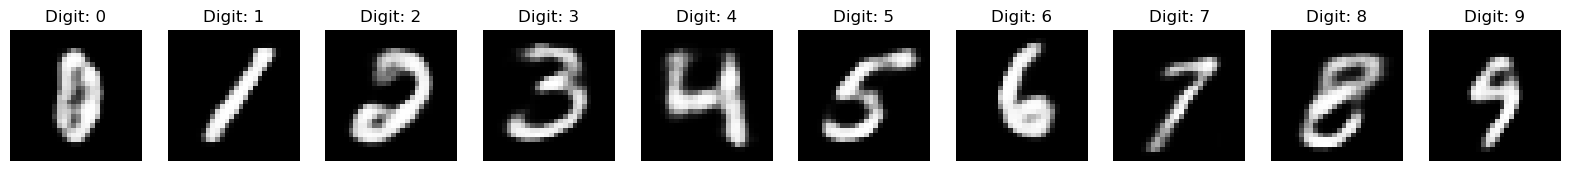

In [107]:
flow_model.eval()
ae_model.eval()

# Generate 10 images, one for each digit
num_generate = 10
labels_to_generate = torch.arange(num_generate).long()
condition_generate = F.one_hot(labels_to_generate, num_classes=10).float().to(device)

with torch.no_grad():
    # Generate new embeddings from the flow model
    generated_embeds = flow_model.sample(num_generate, condition_generate)
    # Decode the embeddings into images
    generated_images = ae_model.decoder(generated_embeds).view(-1, 1, 28, 28)

# Plot the results
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(num_generate):
    ax = axes[i]
    ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Digit: {i}")
    ax.axis('off')
plt.show()

## **🔹 Exercise: Experiment with Hyperparameters**

The quality of the generated images depends on both the Autoencoder's representation and the Normalizing Flow's ability to model it. Try experimenting to see how the results change!

### **📝 Tasks**

1.  **Embedding Dimension**: In the Autoencoder, change `EMBEDDING_DIM`. How does a smaller dimension (e.g., `10`) or a larger one (e.g., `50`) affect the final generated images?
2.  **Flow Depth**: Modify `FLOW_N`, the number of coupling layers in the `LinearRNVP` model. Does a deeper flow (e.g., `12`) produce sharper or more diverse samples? What about a shallower one (e.g., `4`)?
3.  **Network Topology**: Adjust `RNVP_TOPOLOGY`, which controls the size of the hidden networks inside each coupling layer. Try `[100]` or `[400, 400]`. How does the complexity of these networks impact performance and training time?
4.  **Batch Normalization**: Turn off `batch_norm` in the `LinearRNVP` constructor. How does this affect training stability and the final results?


### Contributed by: Ali Habibullah.